In [1]:
from Maze import Maze
import numpy as np
import random
import pygame
import sys
import matplotlib.pyplot as plt
import pandas as pd


pygame 2.1.2 (SDL 2.0.18, Python 3.10.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


### קריאה לסביבה שיצרנו 

In [2]:
env = Maze()
possible_num_state = 189# ספרנו את כל הסטייטים האפשריים במבוכים שיצרנו בהמשך והחסרנו אחד כי בפייתון אנחנו מתחילים מ 0
action_space = 4 # ימינה שמאלה למעלה למטה

#### Q-tableפונקציות של ה
####  פונקציות של המדיניות ,של האימון ושל הדגמה ויזואלית של הסוכן ושל הגרף

In [3]:
def create_qtable(possible_num_state,action_space):
    Qtable = np.zeros((possible_num_state,action_space)) # בהתחלה הטבלה מתחילה עם אפסים ואז מתעדכנת לערכים של Q
    return Qtable


def greedy_policy(Qtable,state):
    action = np.argmax(Qtable[state][:]) #יצירת מדיניות חמדנית שלוקחת את הערך הכי גבוה באותו הסטייט בטבלה

    return action

def epsilon_greedy_policy(Qtable, state, epsilon): # אם האפסילון גדול חוקרים יותר ועושים פעולות רנדומליות ,אם הוא קטן עושים ניצול לידע הקיים 
 
  random_num = random.random()
  
  if random_num > epsilon:
    
    action =greedy_policy(Qtable,state)
  
  else:
    action = random.randint(0, 3)

  return action





In [4]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, Qtable):
    total_rewards_per_episode = [] # פה עשינו את זה נטו לגרף ,כדי שנוכל לעשות פלוט לגרף למטה

    for episode in range(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode) # זו פונקציית הדעיכה של אפסילון 
        state = env.reset()#אתחול של הסביבה לכל אפיזודה ובעצם לגרום לסוכן להתחיל מאותה נקודה כל פעם שהוא נכשל או מצליח במשימה
        total_reward = 0
        done = False

        for step in range(max_steps):##הגבלה של הצעדים שהסוכן יכול לעשות בעיקר כדי שימצא את הדרך היעילה ביותר ולמנוע ממנו לנוע בלופים אינסופיים
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done = env.step(action)
            Qtable[state][action] = Qtable[state][action] + learning_rate * (  
                reward + gamma * max(Qtable[new_state]) - Qtable[state][action]
            ) ## פונקציית Q שמעדכנים בעזרתה את הטבלה 
            total_reward += reward
            state = new_state
            if done: # פה בודקים אם הסוכן נפסל ,או עבר את המשחק בהצלחה אם כן תעבור לאפיזודה הבאה
                break

        total_rewards_per_episode.append(total_reward)

    return Qtable, total_rewards_per_episode


In [5]:
def run_single_episode(env, Q_table, max_steps=200):# זה כדי לראות איך הסוכן מבצע את המשימה אם נכשל או הצליח לפתור את המבוך
    state = env.reset()
    done = False

    pygame.init()

    CELL_SIZE = 80
    ROWS, COLS = 15, 15
    WIDTH, HEIGHT = COLS * CELL_SIZE, ROWS * CELL_SIZE
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Q-Learning Agent Evaluation")
    clock = pygame.time.Clock()

    env.load_images()  

    for _ in range(max_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        action = greedy_policy(Q_table,state)
        state, reward, done = env.step(action)

        env.render(screen)
        pygame.display.flip()
        clock.tick(4)

        if done:
            print("ההדגמה של הסוכן הסתיימה")
            pygame.time.wait(200)
            break

    pygame.quit()  


In [6]:
def moving_average(data, window_size):##פה ספציפית נעזרנו באינטרנט וזו פונקציה ש"מחליקה" את הגרף שלנו של התגמול המצטבר כדי שיוצג קצת יותר טוב ויזואלית , זה הקו האדום בתרשימים בהמשך
    return [np.mean(data[max(0, i - window_size):i + 1]) for i in range(len(data))]


In [7]:
def plot_rewards(rewards, window_size=10):# פונקציית הגרף שמוצג בהמשך 
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Cumulative Reward', alpha=0.5)

    smoothed = moving_average(rewards,window_size)
    plt.plot(smoothed, label=f'Smoothed', color='red')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

#### ניסיון פרמטרים התחלתיים
#### אפיזודות 1500 ,קצב למידה 0.7 ,גאמא 0.95

In [8]:
## פרמטרים
n_training_episodes = 1500
learning_rate = 0.7 
max_steps = 500 
gamma = 0.95
max_epsilon = 1.0 
min_epsilon = 0.05 
decay_rate = 0.005

In [9]:
qtable_maze = create_qtable(possible_num_state,action_space)

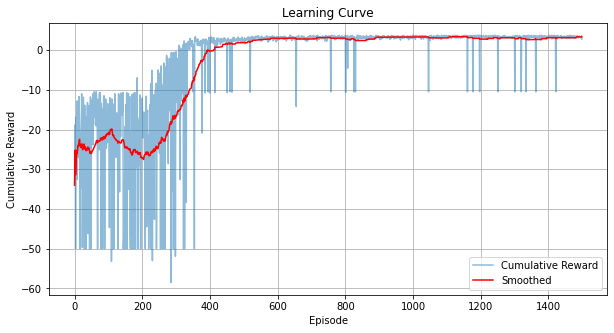

In [10]:
qtable_1, rewards_1 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, qtable_maze)# פה קראנו בעצם לפונקציה של האימון של הסוכן שלנו 



plot_rewards(rewards_1,window_size=60)## פלוט של הגרף של התגמול המצטבר בכל אפיזודה


חשוב לציין שאחרי המצגת של  ,שיפרנו את הקוד וקצת התוצאות השתנו 


In [11]:
run_single_episode(env, qtable_1) # זה כדי לראות איך הסוכן מבצע את המשימה


ההדגמה של הסוכן הסתיימה


## פה בחלק הזה אנחנו בוחנים שילובים של פרמטרים נוספים

חשוב לציין שאנחנו יודעים שיכולנו לעשות גריד סרצ' אבל רצינו לראות ויזואלית וללמוד יותר דרך ניסוי וטעייה 
איך פרמטרים שונים משפיעים על הלמידת של הסוכן

רצינו לראות איך קצב למידה מהיר יותר מהקודם ישפיע על כמות האפיזודות שנתנו לסוכן ללמוד 

בנוסף לאחר ההצגה בכיתה מצאנו פרמטרים יותר טובים מאלה  שלמעלה 


אפסילון קצת יותר נמוך וקצב דעיכה טיפה יותר גבוה ,גורמים לכך שהסוכן לומד ומתייצב משמעותית הרבה יותר מהר 

אנחנו משאירים את מספר האפיזודות לאימון 1500 בעיקר בגלל שאפשר ויזואלית לראות על הגרף את ההתייצבות של המודל ,בסוף נעשה מודל עם מינימום אפיזודות

גאמא=0.95 ,קצב למידה =0.9,מינימום אפסילון אפשרי = 0.005 ,קצב דעיכה = 0.05

In [12]:
## פרמטרים
n_training_episodes = 1500
learning_rate = 0.9 
max_steps = 350
gamma = 0.95
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [13]:
qtable_maze_2 = create_qtable(possible_num_state,action_space)

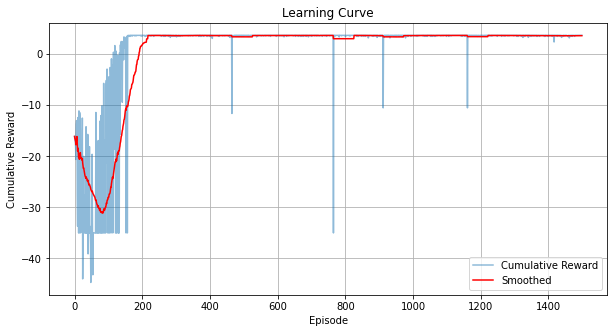

In [14]:
qtable_2, rewards_2 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, qtable_maze_2)

plot_rewards(rewards_2,window_size=60)


ניתן לראות שלאחר שינוי הפרמטרים וההבנה שלנו שהפרמטרים ההתחלתיים היו לא טובים מספיק ואופטימלים ,הסוכן מתייצב לאחר 200 פלוס מינוס אפיזודות

### נבדוק עוד שילובים אפשריים 

גאמא =0.95 ,קצב למידה =0.1 

In [15]:
## פרמטרים
n_training_episodes = 1500
learning_rate = 0.1 
max_steps = 350
gamma = 0.95
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [16]:
qtable_maze_3 = create_qtable(possible_num_state,action_space)

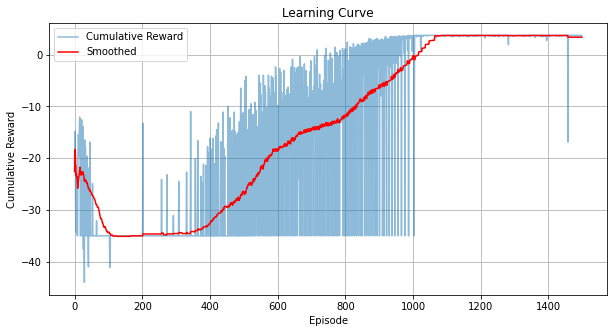

In [17]:
qtable_3, rewards_3 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, qtable_maze_3)

plot_rewards(rewards_3,window_size=60)


אפשר לראות פה שהסוכן באופן מאוד הגיוני לומד לאט ולוקח לו זמן רב להתייצב בגלל קצב הלמידה המואט שנקבע .



גאמא=0.9 קצב למידה = 0.9

In [18]:
## פרמטרים
n_training_episodes = 1500
learning_rate = 0.9 
max_steps = 350
gamma = 0.90
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [19]:
qtable_maze_4 = create_qtable(possible_num_state,action_space)

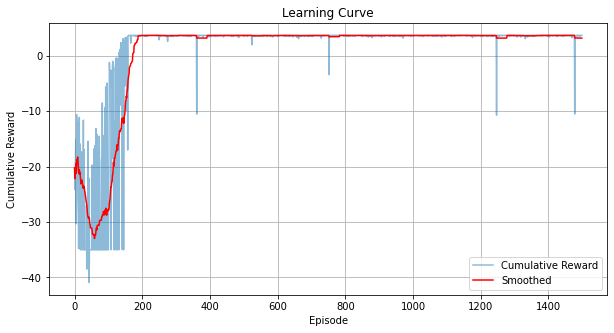

In [20]:
qtable_4, rewards_4 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, qtable_maze_4)

plot_rewards(rewards_4,window_size=30)


פה אפשר לראות שכאשר הגאמא נמוכה יותר הסוכן מתייצב קצת יותר מהר כ-180-200

זאת אומרת ,להתחשב קצת קצת יותר בתגמולים המיידים ולא הרחוקים

## גאמא=0.99 ,קצב למידה = 0.9

In [21]:
## פרמטרים
n_training_episodes = 1500
learning_rate = 0.9 
max_steps = 350
gamma = 0.99
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [22]:
qtable_maze_5 = create_qtable(possible_num_state,action_space)

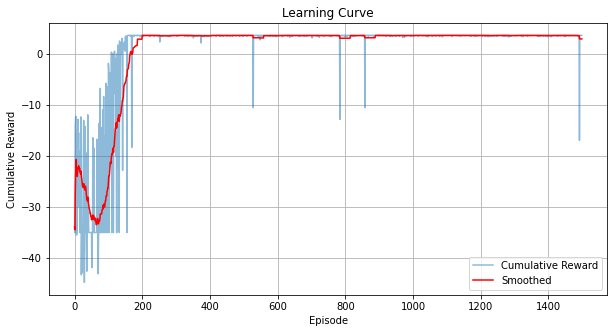

In [23]:
qtable_5, rewards_5 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, qtable_maze_5)

plot_rewards(rewards_5,window_size=30)


להפתעתנו ,התוצאות של גאמא 0.99 ו0.9 דומות מאוד ! 

כאשר הסוכן מתייצב על כ -180-200 אפיזודות 



#### לסיכום

הפרמטרים שבחרנו הם 

אפיזודות =200

קצב למידה =0.9

מספר צעדים מקסימלי =350

גאמא = 0.99

אפסילון מינמלי = 0.005

קצב דעיכה = 0.05


הסוכן מתייצב על 200 אפיזודות ,קצב למידה גבוה ,גאמא 0.99 כדי להתחשב יותר בתגמולים שבעתיד הרחוק ופחות התגמולים המיידיים


## הטבלה האופטימלית 

In [24]:
## פרמטרים
n_training_episodes = 200
learning_rate = 0.9 
max_steps = 350
gamma = 0.99
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [25]:
final_qtable = create_qtable(possible_num_state,action_space)

In [26]:
qtable_5, rewards_5 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps,learning_rate,gamma, final_qtable)


טבלה סופית :

In [27]:
pd.DataFrame(qtable_5)

,0,1,2,3
0,-4.507232,-4.489186,-4.493840,0.618111
1,-4.425672,-4.412084,-4.485331,0.725365
2,-4.388405,-4.354868,-4.401078,0.833702
3,0.305520,0.943133,-4.381970,-4.299493
4,-4.105493,-4.119539,-4.145551,-4.134383
...,...,...,...,...
184,0.000000,0.000000,0.000000,0.000000
185,0.000000,0.000000,0.000000,0.000000
186,0.000000,0.000000,0.000000,0.000000
187,0.000000,0.000000,0.000000,0.000000


In [28]:
run_single_episode(env, qtable_5) # זה כדי לראות איך הסוכן מבצע את המשימה

ההדגמה של הסוכן הסתיימה


## פה אנחנו מראים שהסוכן מצליח לפתור גם מבוכים שונים במבנה שלהם

#### מבוך מספר 2

In [29]:
env2=Maze()

In [30]:
maze2 = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1],
    [1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,1],
    [1,0,1,2,1,0,1,0,1,2,1,0,1,0,1,2,1,0,0,1],
    [1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1],
    [1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1],
    [1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1],
    [1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1],
    [1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1],
    [1,0,1,0,1,0,1,1,1,2,1,1,1,0,1,0,1,0,1,1],
    [1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1],
    [1,0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1],
    [1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1],
    [1,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,1],
    [1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1],
    [1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,1,0,1],
    [1,0,1,2,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1],
    [1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,0,1],
    [1,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
])


In [31]:
env2.maze=maze2

In [32]:
env2=Maze(maze2)

In [33]:
## פרמטרים
n_training_episodes = 200
learning_rate = 0.9 
max_steps = 350
gamma = 0.99
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [34]:
qtable_maze_test_2 = create_qtable(possible_num_state,action_space)
qtable_test_2, rewards_test_2 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env2, max_steps,learning_rate,gamma, qtable_maze_test_2)


In [35]:
run_single_episode(env2, qtable_test_2) # זה כדי לראות איך הסוכן מבצע את המשימה


ההדגמה של הסוכן הסתיימה


#### מבוך מספר 3 

In [36]:
env3=Maze()

In [37]:
maze3 = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1],
    [1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1],
    [1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,2,1,0,1],
    [1,0,1,0,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,1],
    [1,0,1,0,1,2,0,0,0,1,0,0,0,2,0,0,0,1,0,1],
    [1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1],
    [1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1],
    [1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1],
    [1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1],
    [1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1],
    [1,0,0,0,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1],
    [1,0,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1],
    [1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1],
    [1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],
    [1,0,0,0,1,2,0,0,0,1,0,0,0,1,0,0,0,1,0,1],
    [1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1],
    [1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1],
    [1,0,0,0,2,0,0,1,0,0,0,1,0,0,0,2,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
])


In [38]:
env3.maze=maze3

In [39]:
env3=Maze(maze3)

In [40]:
## פרמטרים
n_training_episodes = 200
learning_rate = 0.9 
max_steps = 350
gamma = 0.99
max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05

In [41]:
qtable_maze_test_3 = create_qtable(possible_num_state,action_space)
qtable_test_3, rewards_test_3 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env3, max_steps,learning_rate,gamma, qtable_maze_test_3)


In [42]:
run_single_episode(env3, qtable_test_3) # זה כדי לראות איך הסוכן מבצע את המשימה


ההדגמה של הסוכן הסתיימה


## הקוד הבא שומש בעיקר למצגת ולדוח

In [43]:
table_zeros= create_qtable(186,4)
table_df=pd.DataFrame(table_zeros) # דוגמא לאיך ה q-table ההתחלתי נראה ובכללי איך אתחול הטבלה נראה
table_df

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
181,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0


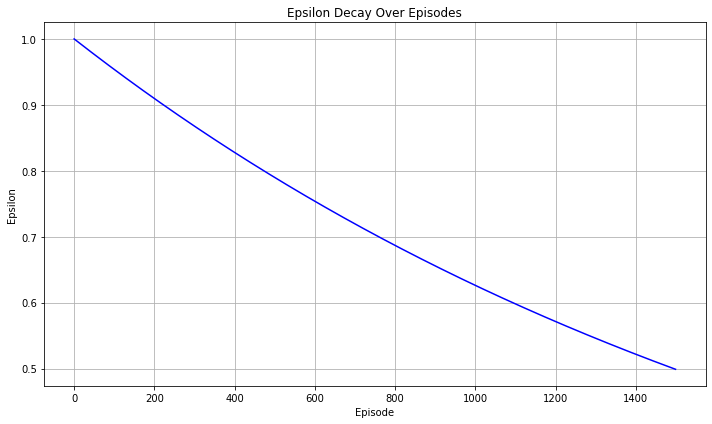

In [44]:

max_epsilon = 1.0 
min_epsilon = 0.05 
decay_rate = 0.0005     
episodes = np.arange(0, 1500) 

# פונקציית דעיכה אקספוננציאלית של האפסילון שלנו
epsilon_values = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episodes)


plt.figure(figsize=(10, 6))
plt.plot(episodes, epsilon_values, label='Epsilon Decay', color='blue')
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.tight_layout()
plt.show()

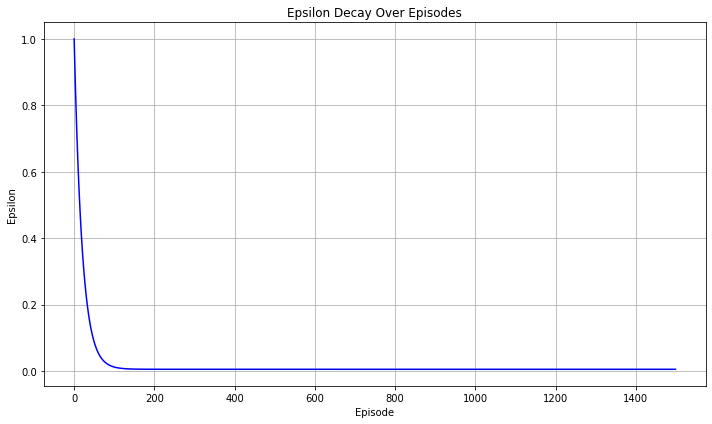

In [45]:

max_epsilon = 1.0 
min_epsilon = 0.005 
decay_rate = 0.05     
episodes = np.arange(0, 1500) 

# פונקציית דעיכה אקספוננציאלית של האפסילון שלנו
epsilon_values = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episodes)


plt.figure(figsize=(10, 6))
plt.plot(episodes, epsilon_values, label='Epsilon Decay', color='blue')
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.tight_layout()
plt.show()